In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import lightgbm as lgb
from copy import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
suumo = pd.read_csv('./data/csv/SuumoDetailsFinal20221108.csv')

# データセット

全て数値で扱えるようにする

In [3]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_recomm = copy(suumo)

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
#    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
    '地価',
]
category_features = [
#    '市区町村',
#    '路線',
#    '駅',
#    '間取り',
#    '向き', # 1
#    '建物種別', # 10
#    '構造',
#    '入居', # 15
#    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = ['家賃']


features = np.r_[
    quantity_features,
#     category_features,
#     is_features,
    target_feature,
]

In [4]:
# 地価変数を導入する
land_price = pd.read_csv('./data/csv/land_price.csv').drop('Unnamed: 0',axis=1)

suumo_recomm = pd.merge(suumo_recomm, land_price, left_on='市区町村', right_on='区', how='left')
suumo_recomm.drop(['市区町村','区'],axis=1,inplace=True)

In [5]:
# 間取りごとの面積の平均
madori_area_mean = suumo_recomm.groupby('間取り', as_index=False).mean()[['間取り','面積']]
suumo_recomm.drop(['面積'],axis=1,inplace=True)
suumo_recomm = pd.merge(suumo_recomm, madori_area_mean, on='間取り', how='left')

In [6]:
# 賃料に対数変換を施す
suumo_recomm['家賃'] = np.log10(suumo_recomm['家賃'])

In [7]:
# Xとyを定義
feature_name = np.r_[
    quantity_features,
#     category_features,
#     is_features,
#     target_feature,
]
X = suumo_recomm[feature_name]
y = suumo_recomm[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [8]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 5000,
#    num_leaves = 1000, 
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

[1]	valid_0's l2: 0.0300563
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0258913
[3]	valid_0's l2: 0.0224833
[4]	valid_0's l2: 0.0197125
[5]	valid_0's l2: 0.0174118
[6]	valid_0's l2: 0.0155422
[7]	valid_0's l2: 0.0139633
[8]	valid_0's l2: 0.0126484
[9]	valid_0's l2: 0.0115611
[10]	valid_0's l2: 0.010651
[11]	valid_0's l2: 0.00989733
[12]	valid_0's l2: 0.00927299
[13]	valid_0's l2: 0.00874128
[14]	valid_0's l2: 0.00827278
[15]	valid_0's l2: 0.00788709
[16]	valid_0's l2: 0.0075682
[17]	valid_0's l2: 0.00729799
[18]	valid_0's l2: 0.00706985
[19]	valid_0's l2: 0.00687505
[20]	valid_0's l2: 0.00671078
[21]	valid_0's l2: 0.00655028
[22]	valid_0's l2: 0.00642481
[23]	valid_0's l2: 0.00632088
[24]	valid_0's l2: 0.00622287
[25]	valid_0's l2: 0.00613283
[26]	valid_0's l2: 0.00606816
[27]	valid_0's l2: 0.00599916
[28]	valid_0's l2: 0.00593985
[29]	valid_0's l2: 0.00588336
[30]	valid_0's l2: 0.00583456
[31]	valid_0's l2: 0.00579146
[32]	valid_0's l2: 0.00575214


[285]	valid_0's l2: 0.00446516
[286]	valid_0's l2: 0.00446183
[287]	valid_0's l2: 0.00445986
[288]	valid_0's l2: 0.00445868
[289]	valid_0's l2: 0.00445801
[290]	valid_0's l2: 0.00445727
[291]	valid_0's l2: 0.00445338
[292]	valid_0's l2: 0.00445251
[293]	valid_0's l2: 0.00445126
[294]	valid_0's l2: 0.00444718
[295]	valid_0's l2: 0.00444655
[296]	valid_0's l2: 0.0044412
[297]	valid_0's l2: 0.00444006
[298]	valid_0's l2: 0.00443578
[299]	valid_0's l2: 0.00443401
[300]	valid_0's l2: 0.00443045
[301]	valid_0's l2: 0.00442861
[302]	valid_0's l2: 0.00442655
[303]	valid_0's l2: 0.00442554
[304]	valid_0's l2: 0.0044247
[305]	valid_0's l2: 0.00442276
[306]	valid_0's l2: 0.00442077
[307]	valid_0's l2: 0.00441631
[308]	valid_0's l2: 0.00441544
[309]	valid_0's l2: 0.00441442
[310]	valid_0's l2: 0.00441318
[311]	valid_0's l2: 0.00441284
[312]	valid_0's l2: 0.00441026
[313]	valid_0's l2: 0.00440587
[314]	valid_0's l2: 0.00440455
[315]	valid_0's l2: 0.00440285
[316]	valid_0's l2: 0.00440236
[317]	vali

[572]	valid_0's l2: 0.00403038
[573]	valid_0's l2: 0.00402875
[574]	valid_0's l2: 0.00402756
[575]	valid_0's l2: 0.00402604
[576]	valid_0's l2: 0.00402484
[577]	valid_0's l2: 0.00402412
[578]	valid_0's l2: 0.00402358
[579]	valid_0's l2: 0.0040221
[580]	valid_0's l2: 0.00402188
[581]	valid_0's l2: 0.00402142
[582]	valid_0's l2: 0.00402101
[583]	valid_0's l2: 0.00402005
[584]	valid_0's l2: 0.00402011
[585]	valid_0's l2: 0.00401899
[586]	valid_0's l2: 0.0040186
[587]	valid_0's l2: 0.00401852
[588]	valid_0's l2: 0.00401773
[589]	valid_0's l2: 0.00401706
[590]	valid_0's l2: 0.00401645
[591]	valid_0's l2: 0.00401555
[592]	valid_0's l2: 0.00401495
[593]	valid_0's l2: 0.00401441
[594]	valid_0's l2: 0.00401353
[595]	valid_0's l2: 0.0040129
[596]	valid_0's l2: 0.00401158
[597]	valid_0's l2: 0.0040111
[598]	valid_0's l2: 0.00401034
[599]	valid_0's l2: 0.00400938
[600]	valid_0's l2: 0.00400844
[601]	valid_0's l2: 0.00400796
[602]	valid_0's l2: 0.00400709
[603]	valid_0's l2: 0.00400631
[604]	valid_

[874]	valid_0's l2: 0.00374641
[875]	valid_0's l2: 0.00374578
[876]	valid_0's l2: 0.00374513
[877]	valid_0's l2: 0.00374485
[878]	valid_0's l2: 0.00374416
[879]	valid_0's l2: 0.00374313
[880]	valid_0's l2: 0.00374294
[881]	valid_0's l2: 0.00374279
[882]	valid_0's l2: 0.00374207
[883]	valid_0's l2: 0.00374146
[884]	valid_0's l2: 0.00374065
[885]	valid_0's l2: 0.00374021
[886]	valid_0's l2: 0.00373975
[887]	valid_0's l2: 0.00373899
[888]	valid_0's l2: 0.00373756
[889]	valid_0's l2: 0.00373636
[890]	valid_0's l2: 0.00373533
[891]	valid_0's l2: 0.00373431
[892]	valid_0's l2: 0.00373376
[893]	valid_0's l2: 0.0037335
[894]	valid_0's l2: 0.00373308
[895]	valid_0's l2: 0.00373247
[896]	valid_0's l2: 0.00373143
[897]	valid_0's l2: 0.00373028
[898]	valid_0's l2: 0.00373014
[899]	valid_0's l2: 0.0037296
[900]	valid_0's l2: 0.00372909
[901]	valid_0's l2: 0.00372729
[902]	valid_0's l2: 0.00372703
[903]	valid_0's l2: 0.00372686
[904]	valid_0's l2: 0.00372515
[905]	valid_0's l2: 0.0037243
[906]	valid

[1164]	valid_0's l2: 0.00356327
[1165]	valid_0's l2: 0.00356262
[1166]	valid_0's l2: 0.00356211
[1167]	valid_0's l2: 0.00356197
[1168]	valid_0's l2: 0.00356102
[1169]	valid_0's l2: 0.00356082
[1170]	valid_0's l2: 0.00356047
[1171]	valid_0's l2: 0.0035603
[1172]	valid_0's l2: 0.00355997
[1173]	valid_0's l2: 0.00355902
[1174]	valid_0's l2: 0.00355838
[1175]	valid_0's l2: 0.00355807
[1176]	valid_0's l2: 0.00355743
[1177]	valid_0's l2: 0.00355709
[1178]	valid_0's l2: 0.00355639
[1179]	valid_0's l2: 0.00355632
[1180]	valid_0's l2: 0.00355577
[1181]	valid_0's l2: 0.00355499
[1182]	valid_0's l2: 0.00355503
[1183]	valid_0's l2: 0.00355518
[1184]	valid_0's l2: 0.00355434
[1185]	valid_0's l2: 0.00355364
[1186]	valid_0's l2: 0.00355335
[1187]	valid_0's l2: 0.00355278
[1188]	valid_0's l2: 0.00355205
[1189]	valid_0's l2: 0.00355193
[1190]	valid_0's l2: 0.0035516
[1191]	valid_0's l2: 0.00355095
[1192]	valid_0's l2: 0.00355086
[1193]	valid_0's l2: 0.0035504
[1194]	valid_0's l2: 0.00354981
[1195]	vali

[1460]	valid_0's l2: 0.00341428
[1461]	valid_0's l2: 0.00341392
[1462]	valid_0's l2: 0.00341385
[1463]	valid_0's l2: 0.0034137
[1464]	valid_0's l2: 0.0034135
[1465]	valid_0's l2: 0.00341274
[1466]	valid_0's l2: 0.00341265
[1467]	valid_0's l2: 0.00341237
[1468]	valid_0's l2: 0.00341202
[1469]	valid_0's l2: 0.0034115
[1470]	valid_0's l2: 0.00341092
[1471]	valid_0's l2: 0.00341012
[1472]	valid_0's l2: 0.00340949
[1473]	valid_0's l2: 0.00340913
[1474]	valid_0's l2: 0.00340896
[1475]	valid_0's l2: 0.00340872
[1476]	valid_0's l2: 0.00340864
[1477]	valid_0's l2: 0.00340802
[1478]	valid_0's l2: 0.00340682
[1479]	valid_0's l2: 0.00340622
[1480]	valid_0's l2: 0.00340601
[1481]	valid_0's l2: 0.00340574
[1482]	valid_0's l2: 0.00340554
[1483]	valid_0's l2: 0.0034047
[1484]	valid_0's l2: 0.0034044
[1485]	valid_0's l2: 0.00340356
[1486]	valid_0's l2: 0.00340314
[1487]	valid_0's l2: 0.00340285
[1488]	valid_0's l2: 0.00340249
[1489]	valid_0's l2: 0.00340236
[1490]	valid_0's l2: 0.0034019
[1491]	valid_0

[1723]	valid_0's l2: 0.00330085
[1724]	valid_0's l2: 0.00330061
[1725]	valid_0's l2: 0.00330027
[1726]	valid_0's l2: 0.00330002
[1727]	valid_0's l2: 0.00329984
[1728]	valid_0's l2: 0.00329973
[1729]	valid_0's l2: 0.00329919
[1730]	valid_0's l2: 0.00329885
[1731]	valid_0's l2: 0.00329836
[1732]	valid_0's l2: 0.00329808
[1733]	valid_0's l2: 0.00329774
[1734]	valid_0's l2: 0.00329771
[1735]	valid_0's l2: 0.00329754
[1736]	valid_0's l2: 0.00329728
[1737]	valid_0's l2: 0.00329713
[1738]	valid_0's l2: 0.00329679
[1739]	valid_0's l2: 0.00329671
[1740]	valid_0's l2: 0.003296
[1741]	valid_0's l2: 0.00329569
[1742]	valid_0's l2: 0.00329565
[1743]	valid_0's l2: 0.00329536
[1744]	valid_0's l2: 0.0032946
[1745]	valid_0's l2: 0.00329406
[1746]	valid_0's l2: 0.00329372
[1747]	valid_0's l2: 0.00329342
[1748]	valid_0's l2: 0.0032931
[1749]	valid_0's l2: 0.00329244
[1750]	valid_0's l2: 0.00329208
[1751]	valid_0's l2: 0.00329189
[1752]	valid_0's l2: 0.00329158
[1753]	valid_0's l2: 0.0032914
[1754]	valid_

[2034]	valid_0's l2: 0.00319048
[2035]	valid_0's l2: 0.00318995
[2036]	valid_0's l2: 0.00318967
[2037]	valid_0's l2: 0.00318938
[2038]	valid_0's l2: 0.00318943
[2039]	valid_0's l2: 0.00318918
[2040]	valid_0's l2: 0.00318913
[2041]	valid_0's l2: 0.00318869
[2042]	valid_0's l2: 0.00318771
[2043]	valid_0's l2: 0.00318757
[2044]	valid_0's l2: 0.00318727
[2045]	valid_0's l2: 0.00318692
[2046]	valid_0's l2: 0.00318683
[2047]	valid_0's l2: 0.0031867
[2048]	valid_0's l2: 0.0031865
[2049]	valid_0's l2: 0.00318613
[2050]	valid_0's l2: 0.00318563
[2051]	valid_0's l2: 0.0031855
[2052]	valid_0's l2: 0.00318522
[2053]	valid_0's l2: 0.00318475
[2054]	valid_0's l2: 0.0031849
[2055]	valid_0's l2: 0.00318462
[2056]	valid_0's l2: 0.00318458
[2057]	valid_0's l2: 0.00318415
[2058]	valid_0's l2: 0.00318421
[2059]	valid_0's l2: 0.00318411
[2060]	valid_0's l2: 0.0031837
[2061]	valid_0's l2: 0.00318327
[2062]	valid_0's l2: 0.00318311
[2063]	valid_0's l2: 0.00318279
[2064]	valid_0's l2: 0.0031827
[2065]	valid_0

[2319]	valid_0's l2: 0.00311523
[2320]	valid_0's l2: 0.0031147
[2321]	valid_0's l2: 0.0031142
[2322]	valid_0's l2: 0.00311382
[2323]	valid_0's l2: 0.00311325
[2324]	valid_0's l2: 0.00311279
[2325]	valid_0's l2: 0.00311231
[2326]	valid_0's l2: 0.00311212
[2327]	valid_0's l2: 0.00311202
[2328]	valid_0's l2: 0.0031118
[2329]	valid_0's l2: 0.00311171
[2330]	valid_0's l2: 0.0031115
[2331]	valid_0's l2: 0.00311128
[2332]	valid_0's l2: 0.00311077
[2333]	valid_0's l2: 0.00311049
[2334]	valid_0's l2: 0.00311039
[2335]	valid_0's l2: 0.00310976
[2336]	valid_0's l2: 0.00310958
[2337]	valid_0's l2: 0.00310924
[2338]	valid_0's l2: 0.00310914
[2339]	valid_0's l2: 0.00310865
[2340]	valid_0's l2: 0.00310863
[2341]	valid_0's l2: 0.00310781
[2342]	valid_0's l2: 0.0031076
[2343]	valid_0's l2: 0.00310753
[2344]	valid_0's l2: 0.00310695
[2345]	valid_0's l2: 0.00310666
[2346]	valid_0's l2: 0.00310656
[2347]	valid_0's l2: 0.00310638
[2348]	valid_0's l2: 0.00310605
[2349]	valid_0's l2: 0.0031058
[2350]	valid_0

[2621]	valid_0's l2: 0.00303884
[2622]	valid_0's l2: 0.00303852
[2623]	valid_0's l2: 0.00303827
[2624]	valid_0's l2: 0.00303811
[2625]	valid_0's l2: 0.00303813
[2626]	valid_0's l2: 0.00303788
[2627]	valid_0's l2: 0.00303764
[2628]	valid_0's l2: 0.00303738
[2629]	valid_0's l2: 0.00303687
[2630]	valid_0's l2: 0.00303653
[2631]	valid_0's l2: 0.00303625
[2632]	valid_0's l2: 0.00303583
[2633]	valid_0's l2: 0.00303576
[2634]	valid_0's l2: 0.00303569
[2635]	valid_0's l2: 0.0030353
[2636]	valid_0's l2: 0.00303541
[2637]	valid_0's l2: 0.00303494
[2638]	valid_0's l2: 0.00303483
[2639]	valid_0's l2: 0.00303447
[2640]	valid_0's l2: 0.00303424
[2641]	valid_0's l2: 0.00303392
[2642]	valid_0's l2: 0.00303367
[2643]	valid_0's l2: 0.003033
[2644]	valid_0's l2: 0.0030328
[2645]	valid_0's l2: 0.00303248
[2646]	valid_0's l2: 0.00303229
[2647]	valid_0's l2: 0.00303202
[2648]	valid_0's l2: 0.00303163
[2649]	valid_0's l2: 0.00303156
[2650]	valid_0's l2: 0.00303131
[2651]	valid_0's l2: 0.00303111
[2652]	valid

[2887]	valid_0's l2: 0.00297449
[2888]	valid_0's l2: 0.00297437
[2889]	valid_0's l2: 0.00297404
[2890]	valid_0's l2: 0.00297356
[2891]	valid_0's l2: 0.00297351
[2892]	valid_0's l2: 0.00297337
[2893]	valid_0's l2: 0.00297324
[2894]	valid_0's l2: 0.00297286
[2895]	valid_0's l2: 0.00297271
[2896]	valid_0's l2: 0.00297266
[2897]	valid_0's l2: 0.00297246
[2898]	valid_0's l2: 0.00297209
[2899]	valid_0's l2: 0.00297204
[2900]	valid_0's l2: 0.00297177
[2901]	valid_0's l2: 0.00297163
[2902]	valid_0's l2: 0.00297131
[2903]	valid_0's l2: 0.00297123
[2904]	valid_0's l2: 0.00297093
[2905]	valid_0's l2: 0.00297062
[2906]	valid_0's l2: 0.00297054
[2907]	valid_0's l2: 0.00297052
[2908]	valid_0's l2: 0.00297019
[2909]	valid_0's l2: 0.00297021
[2910]	valid_0's l2: 0.00297009
[2911]	valid_0's l2: 0.00296994
[2912]	valid_0's l2: 0.00296963
[2913]	valid_0's l2: 0.00296946
[2914]	valid_0's l2: 0.0029692
[2915]	valid_0's l2: 0.00296892
[2916]	valid_0's l2: 0.00296855
[2917]	valid_0's l2: 0.00296805
[2918]	va

[3191]	valid_0's l2: 0.00291874
[3192]	valid_0's l2: 0.00291864
[3193]	valid_0's l2: 0.00291848
[3194]	valid_0's l2: 0.00291836
[3195]	valid_0's l2: 0.00291803
[3196]	valid_0's l2: 0.00291762
[3197]	valid_0's l2: 0.00291739
[3198]	valid_0's l2: 0.00291723
[3199]	valid_0's l2: 0.00291723
[3200]	valid_0's l2: 0.00291709
[3201]	valid_0's l2: 0.00291673
[3202]	valid_0's l2: 0.00291657
[3203]	valid_0's l2: 0.00291637
[3204]	valid_0's l2: 0.00291609
[3205]	valid_0's l2: 0.00291617
[3206]	valid_0's l2: 0.00291606
[3207]	valid_0's l2: 0.0029158
[3208]	valid_0's l2: 0.00291569
[3209]	valid_0's l2: 0.00291574
[3210]	valid_0's l2: 0.00291564
[3211]	valid_0's l2: 0.00291549
[3212]	valid_0's l2: 0.00291481
[3213]	valid_0's l2: 0.00291461
[3214]	valid_0's l2: 0.00291437
[3215]	valid_0's l2: 0.00291439
[3216]	valid_0's l2: 0.00291428
[3217]	valid_0's l2: 0.00291422
[3218]	valid_0's l2: 0.00291385
[3219]	valid_0's l2: 0.00291353
[3220]	valid_0's l2: 0.00291321
[3221]	valid_0's l2: 0.00291306
[3222]	va

[3485]	valid_0's l2: 0.0028672
[3486]	valid_0's l2: 0.00286691
[3487]	valid_0's l2: 0.00286707
[3488]	valid_0's l2: 0.00286687
[3489]	valid_0's l2: 0.00286686
[3490]	valid_0's l2: 0.00286653
[3491]	valid_0's l2: 0.00286633
[3492]	valid_0's l2: 0.00286636
[3493]	valid_0's l2: 0.00286633
[3494]	valid_0's l2: 0.00286631
[3495]	valid_0's l2: 0.00286609
[3496]	valid_0's l2: 0.00286608
[3497]	valid_0's l2: 0.00286594
[3498]	valid_0's l2: 0.00286584
[3499]	valid_0's l2: 0.00286584
[3500]	valid_0's l2: 0.00286554
[3501]	valid_0's l2: 0.00286509
[3502]	valid_0's l2: 0.00286504
[3503]	valid_0's l2: 0.00286476
[3504]	valid_0's l2: 0.00286464
[3505]	valid_0's l2: 0.00286453
[3506]	valid_0's l2: 0.00286444
[3507]	valid_0's l2: 0.00286413
[3508]	valid_0's l2: 0.00286407
[3509]	valid_0's l2: 0.00286396
[3510]	valid_0's l2: 0.00286388
[3511]	valid_0's l2: 0.00286356
[3512]	valid_0's l2: 0.00286338
[3513]	valid_0's l2: 0.00286318
[3514]	valid_0's l2: 0.00286303
[3515]	valid_0's l2: 0.00286288
[3516]	va

[3790]	valid_0's l2: 0.00282685
[3791]	valid_0's l2: 0.00282649
[3792]	valid_0's l2: 0.00282619
[3793]	valid_0's l2: 0.00282618
[3794]	valid_0's l2: 0.00282596
[3795]	valid_0's l2: 0.00282585
[3796]	valid_0's l2: 0.00282585
[3797]	valid_0's l2: 0.0028255
[3798]	valid_0's l2: 0.00282539
[3799]	valid_0's l2: 0.00282523
[3800]	valid_0's l2: 0.00282507
[3801]	valid_0's l2: 0.00282505
[3802]	valid_0's l2: 0.00282499
[3803]	valid_0's l2: 0.00282458
[3804]	valid_0's l2: 0.00282454
[3805]	valid_0's l2: 0.00282439
[3806]	valid_0's l2: 0.00282422
[3807]	valid_0's l2: 0.00282414
[3808]	valid_0's l2: 0.00282396
[3809]	valid_0's l2: 0.00282397
[3810]	valid_0's l2: 0.00282395
[3811]	valid_0's l2: 0.0028237
[3812]	valid_0's l2: 0.00282367
[3813]	valid_0's l2: 0.00282356
[3814]	valid_0's l2: 0.00282339
[3815]	valid_0's l2: 0.00282336
[3816]	valid_0's l2: 0.00282318
[3817]	valid_0's l2: 0.00282293
[3818]	valid_0's l2: 0.00282285
[3819]	valid_0's l2: 0.00282275
[3820]	valid_0's l2: 0.00282267
[3821]	val

[4068]	valid_0's l2: 0.00278882
[4069]	valid_0's l2: 0.00278871
[4070]	valid_0's l2: 0.00278847
[4071]	valid_0's l2: 0.00278825
[4072]	valid_0's l2: 0.00278812
[4073]	valid_0's l2: 0.00278811
[4074]	valid_0's l2: 0.00278788
[4075]	valid_0's l2: 0.00278767
[4076]	valid_0's l2: 0.00278749
[4077]	valid_0's l2: 0.00278756
[4078]	valid_0's l2: 0.00278755
[4079]	valid_0's l2: 0.00278722
[4080]	valid_0's l2: 0.0027872
[4081]	valid_0's l2: 0.00278708
[4082]	valid_0's l2: 0.00278696
[4083]	valid_0's l2: 0.00278693
[4084]	valid_0's l2: 0.00278688
[4085]	valid_0's l2: 0.00278682
[4086]	valid_0's l2: 0.00278678
[4087]	valid_0's l2: 0.00278669
[4088]	valid_0's l2: 0.0027865
[4089]	valid_0's l2: 0.00278639
[4090]	valid_0's l2: 0.00278606
[4091]	valid_0's l2: 0.00278593
[4092]	valid_0's l2: 0.00278581
[4093]	valid_0's l2: 0.00278566
[4094]	valid_0's l2: 0.00278547
[4095]	valid_0's l2: 0.00278543
[4096]	valid_0's l2: 0.00278533
[4097]	valid_0's l2: 0.00278525
[4098]	valid_0's l2: 0.0027852
[4099]	vali

[4325]	valid_0's l2: 0.00275964
[4326]	valid_0's l2: 0.00275959
[4327]	valid_0's l2: 0.00275961
[4328]	valid_0's l2: 0.00275937
[4329]	valid_0's l2: 0.00275921
[4330]	valid_0's l2: 0.00275882
[4331]	valid_0's l2: 0.00275877
[4332]	valid_0's l2: 0.00275874
[4333]	valid_0's l2: 0.00275874
[4334]	valid_0's l2: 0.00275859
[4335]	valid_0's l2: 0.00275857
[4336]	valid_0's l2: 0.00275825
[4337]	valid_0's l2: 0.00275826
[4338]	valid_0's l2: 0.00275824
[4339]	valid_0's l2: 0.00275819
[4340]	valid_0's l2: 0.00275806
[4341]	valid_0's l2: 0.00275794
[4342]	valid_0's l2: 0.00275797
[4343]	valid_0's l2: 0.00275794
[4344]	valid_0's l2: 0.00275798
[4345]	valid_0's l2: 0.00275796
[4346]	valid_0's l2: 0.00275792
[4347]	valid_0's l2: 0.00275788
[4348]	valid_0's l2: 0.0027579
[4349]	valid_0's l2: 0.0027579
[4350]	valid_0's l2: 0.00275794
[4351]	valid_0's l2: 0.00275785
[4352]	valid_0's l2: 0.00275771
[4353]	valid_0's l2: 0.00275751
[4354]	valid_0's l2: 0.00275739
[4355]	valid_0's l2: 0.00275726
[4356]	val

[4601]	valid_0's l2: 0.00272791
[4602]	valid_0's l2: 0.00272789
[4603]	valid_0's l2: 0.0027277
[4604]	valid_0's l2: 0.0027277
[4605]	valid_0's l2: 0.00272761
[4606]	valid_0's l2: 0.00272746
[4607]	valid_0's l2: 0.0027275
[4608]	valid_0's l2: 0.0027274
[4609]	valid_0's l2: 0.00272741
[4610]	valid_0's l2: 0.00272743
[4611]	valid_0's l2: 0.00272733
[4612]	valid_0's l2: 0.00272742
[4613]	valid_0's l2: 0.00272728
[4614]	valid_0's l2: 0.00272692
[4615]	valid_0's l2: 0.0027267
[4616]	valid_0's l2: 0.0027265
[4617]	valid_0's l2: 0.00272637
[4618]	valid_0's l2: 0.00272629
[4619]	valid_0's l2: 0.00272606
[4620]	valid_0's l2: 0.00272594
[4621]	valid_0's l2: 0.0027259
[4622]	valid_0's l2: 0.00272589
[4623]	valid_0's l2: 0.00272587
[4624]	valid_0's l2: 0.00272571
[4625]	valid_0's l2: 0.00272579
[4626]	valid_0's l2: 0.00272554
[4627]	valid_0's l2: 0.0027255
[4628]	valid_0's l2: 0.00272557
[4629]	valid_0's l2: 0.0027255
[4630]	valid_0's l2: 0.00272548
[4631]	valid_0's l2: 0.00272539
[4632]	valid_0's 

[4876]	valid_0's l2: 0.00269926
[4877]	valid_0's l2: 0.00269919
[4878]	valid_0's l2: 0.00269903
[4879]	valid_0's l2: 0.00269902
[4880]	valid_0's l2: 0.00269894
[4881]	valid_0's l2: 0.00269871
[4882]	valid_0's l2: 0.0026988
[4883]	valid_0's l2: 0.00269879
[4884]	valid_0's l2: 0.00269871
[4885]	valid_0's l2: 0.00269867
[4886]	valid_0's l2: 0.00269857
[4887]	valid_0's l2: 0.00269845
[4888]	valid_0's l2: 0.00269829
[4889]	valid_0's l2: 0.00269813
[4890]	valid_0's l2: 0.00269801
[4891]	valid_0's l2: 0.00269783
[4892]	valid_0's l2: 0.0026979
[4893]	valid_0's l2: 0.00269739
[4894]	valid_0's l2: 0.00269729
[4895]	valid_0's l2: 0.0026973
[4896]	valid_0's l2: 0.00269722
[4897]	valid_0's l2: 0.00269724
[4898]	valid_0's l2: 0.0026969
[4899]	valid_0's l2: 0.00269684
[4900]	valid_0's l2: 0.00269668
[4901]	valid_0's l2: 0.00269667
[4902]	valid_0's l2: 0.00269662
[4903]	valid_0's l2: 0.00269668
[4904]	valid_0's l2: 0.00269658
[4905]	valid_0's l2: 0.00269652
[4906]	valid_0's l2: 0.00269656
[4907]	valid

LGBMRegressor(importance_type='gain', n_estimators=5000, random_state=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

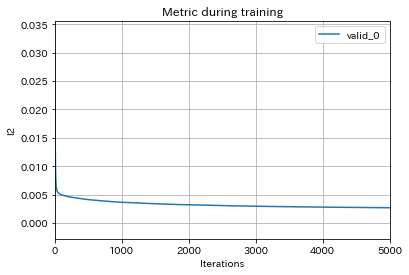

In [9]:
lgb.plot_metric(LGBM)

In [10]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [11]:
# それぞれのr2スコアを算出

print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9620053211623724
valid: 0.8990201005869426
test: 0.8988416189159472


In [12]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 2.4253445604026798
valid: 6.304809749733785
test: 6.263218202753072


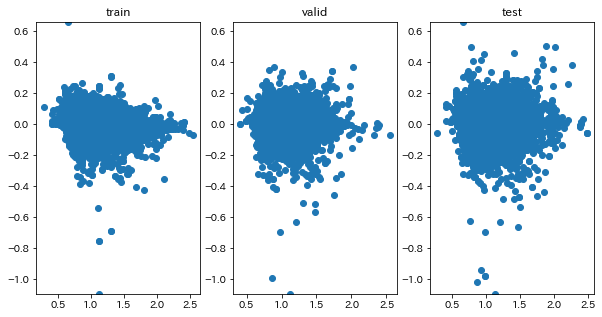

In [13]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train.values.reshape(-1)
error_valid = y_valid_pred - y_valid.values.reshape(-1)
error_test = y_test_pred - y_test.values.reshape(-1)

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [14]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[feature_name, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

,feature,importance
0,最寄駅からの距離,684.472142
1,面積,11582.697626
2,築年数,2060.420048
3,地上,2088.572054
4,階,254.330958
5,地価,3124.851778


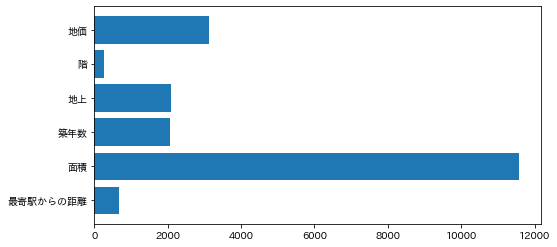

In [15]:
# 変数重要度
plt.figure(figsize=(8,4))
plt.barh(table_importances['feature'],table_importances['importance'])
# plt.savefig("./data/image/elite_feature_importances.png")
plt.show()

# 物件同士の類似度を測る

In [175]:
# 数が多い相手に限定するゾ
floor_plan = ["1K","1","1LDK","1DK","2DK","2LDK ","2K","3LDK","3DK","2SLDK","1SK"]
condition = [suumo.loc[i,'間取り'] in floor_plan for i in range(suumo.shape[0])]

In [176]:
# サンプルを取る
suumo_recomm = copy(suumo[condition].sample(1000))

In [177]:
# 地価変数
suumo_recomm = pd.merge(suumo_recomm, land_price, left_on='市区町村',right_on='区')

In [178]:
# 間取り⇔面積テーブル
transform_floor_plan_area = suumo_recomm.groupby('間取り', as_index=False).mean()[['間取り','面積']]
transform_floor_plan_area['面積'] = transform_floor_plan_area['面積'].round(2)

In [179]:
# データを絞る
suumo_recomm = suumo_recomm[["最寄駅からの距離","間取り","築年数","地上","階","地価","家賃","url"]]

In [180]:
# 間取りを面積に変える
suumo_recomm['面積'] = suumo_recomm['間取り'].map(lambda x: transform_floor_plan_area.loc[transform_floor_plan_area['間取り'] == x,'面積'].values[0])

In [181]:
# 家賃を対数に
suumo_recomm['家賃'] = np.log10(suumo_recomm['家賃'])

In [182]:
# 整形
suumo_recomm_ss = suumo_recomm[features]

In [183]:
suumo_recomm_ss['url'] = suumo_recomm['url']

C:\Users\doubl\AppData\Local\Temp\ipykernel_33712\2260349914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  suumo_recomm_ss['url'] = suumo_recomm['url']


In [184]:
suumo_recomm = copy(suumo_recomm_ss)

In [185]:
suumo_recomm_copy = copy(suumo_recomm_ss)

In [189]:
# 標準化
suumo_recomm_copy = copy(suumo_recomm)
suumo_recomm_ss = copy(suumo_recomm_copy)
ss = StandardScaler()
ss.fit(suumo_recomm_copy[features])
suumo_recomm_ss[features] = ss.transform(suumo_recomm_copy[features])
suumo_recomm_ss = suumo_recomm_ss[features]
suumo_recomm_ss['url'] = suumo_recomm_copy['url']

In [385]:
suumo_recomm.to_csv('./data/csv/suumo_recomm.csv', index=False)

,最寄駅からの距離,面積,築年数,地上,階,地価,家賃,url
0,441.890292,23.363426,16,9,2.0,2422709,0.886491,https://suumo.jp/chintai/jnc_000077632901/?bc=...
1,423.077742,23.363426,21,4,3.0,3411426,0.880814,https://suumo.jp/chintai/jnc_000077105470/?bc=...
2,846.155490,23.363426,33,3,2.0,2448394,0.838849,https://suumo.jp/chintai/jnc_000076939553/?bc=...
3,1126.603615,23.363426,3,10,4.0,14625228,1.113943,https://suumo.jp/chintai/jnc_000075090544/?bc=...
4,841.334057,20.344868,22,11,7.0,2422709,0.857332,https://suumo.jp/chintai/jnc_000076916521/?bc=...
...,...,...,...,...,...,...,...,...
995,821.765470,41.433898,21,3,2.0,2457808,1.204120,https://suumo.jp/chintai/jnc_000054487471/?bc=...
996,548.668089,20.344868,33,3,1.0,1854132,0.740363,https://suumo.jp/chintai/jnc_000050241615/?bc=...
997,337.499287,23.363426,3,3,3.0,1496795,0.826075,https://suumo.jp/chintai/jnc_000057493190/?bc=...
998,765.376443,23.363426,4,6,4.0,1545083,0.857332,https://suumo.jp/chintai/jnc_000077270084/?bc=...


In [191]:
# コサイン類似度
def cos_sim(v1,v2):
    dot = np.dot(v1,v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    sim = dot/(norm1*norm2)
    return sim

In [192]:
cos_sim(suumo_recomm_ss.iloc[0,:-1],suumo_recomm_ss.iloc[1,:-1])

0.06959568682476311

In [193]:
# 処理
# 駅徒歩[分]を最寄までの距離に直す
    # 分速80mで解決
# 間取りを面積情報に変える
    # 対応表を用意しておく
# 市区町村を地価情報に変える
    # 対応表を用意しておく
# a家賃を対数に変換 
# 変換された物件条件をもとに類似度を計算
# 類似度の高い物件のidを取得
# idをもとに物件情報を提示する

In [386]:
transform_floor_plan_area.to_csv("./data/csv/transform_floor_plan_area.csv", index=False)

In [387]:
# 適当に作った物件に近い物件を探す

ideal_rent = {
    '駅徒歩':10,
    '間取り':'2SLDK',
    '築年数':10,
    '地上':3,
    '階':2,
    '区':'世田谷区',
    '家賃':10,
}

In [388]:
# 駅徒歩を変換
ideal_rent['最寄駅からの距離'] = ideal_rent['駅徒歩']*100

In [389]:
# 間取りを変換
# その場で計算してもいいけどテーブルを用意してもいいかもね
condition = transform_floor_plan_area['間取り'] == ideal_rent['間取り']
ideal_rent['面積'] = transform_floor_plan_area.loc[condition,'面積'].values[0]

In [390]:
# 地価を変換
# その場で計算してもいいけどテーブルを用意してもいいかもね
condition = land_price['区'] == ideal_rent['区']
ideal_rent['地価'] = land_price.loc[condition,'地価'].values[0]

In [391]:
# 家賃を変換
ideal_rent['家賃'] = np.log10(ideal_rent['家賃'])

In [392]:
# 整形
df_ideal = pd.DataFrame(ideal_rent.values()).T
df_ideal.columns = ideal_rent.keys()
df_ideal[features]

,最寄駅からの距離,面積,築年数,地上,階,地価,家賃
0,1000,73.98,10,3,2,2448394,1.0


In [393]:
# 標準化を適用
df_ideal_ss = copy(df_ideal)
df_ideal_ss[features] = ss.transform(df_ideal[features])
df_ideal_ss.loc[0,features]

最寄駅からの距離    1.167089
面積          4.063505
築年数        -0.492492
地上         -0.669555
階          -0.520922
地価         -0.450701
家賃          0.247582
Name: 0, dtype: object

In [394]:
df_ideal_ss[features].values

array([[ 1.16708883,  4.0635046 , -0.49249194, -0.66955545, -0.52092245,
        -0.45070109,  0.24758157]])

In [395]:
# 適当な物件を拾って類似している物件を探す

# 物件の類似度を計算
vec_sim = suumo_recomm_ss.apply(lambda x: cos_sim(x[features],df_ideal_ss.loc[0,features]),axis=1)

# 一番類似している物件を3件
num = vec_sim.nlargest(3).index.tolist()
max_ = vec_sim.nlargest(3).values.tolist()
print(num,max_)

[65, 287, 532] [0.959540247265088, 0.9549713646772913, 0.9424171121481366]


In [396]:
# 類似度の高い物件
suumo_recomm_ss.loc[num[0]]

最寄駅からの距離                                             0.647121
面積                                                   4.598562
築年数                                                 -1.201317
地上                                                  -0.669555
階                                                   -0.845687
地価                                                  -0.651494
家賃                                                   1.343957
url         https://suumo.jp/chintai/jnc_000076886892/?bc=...
Name: 65, dtype: object

In [397]:
# 条件に入れた物件
df_ideal.loc[0]

駅徒歩              10
間取り           2SLDK
築年数              10
地上                3
階                 2
区              世田谷区
家賃              1.0
最寄駅からの距離       1000
面積            73.98
地価          2448394
Name: 0, dtype: object

In [417]:
# 変形したデータをもとに戻す

# フォームデータ
ideal_rent['家賃'] = 10**ideal_rent['家賃']

# 物件データ
recomm_rent = ss.inverse_transform(suumo_recomm_ss.loc[num,features])
recomm_rent = pd.DataFrame(recomm_rent,index=num, columns=features)

# 面積→間取り
recomm_rent['間取り'] = recomm_rent['面積'].map(lambda x: transform_floor_plan_area.loc[transform_floor_plan_area['面積'] == x,'間取り'].values[0])

# 地価→区
recomm_rent['区'] = recomm_rent['地価'].map(lambda x: land_price.loc[land_price['地価'] == round(x),'区'].values[0])

# 最寄駅からの距離→駅徒歩
recomm_rent['駅徒歩'] = (recomm_rent['最寄駅からの距離']/100).astype(int)
    
# 家賃をもとに戻す
recomm_rent['家賃'] = 10**(recomm_rent['家賃'])

# urlを与える
recomm_rent['url'] = suumo_recomm_ss.loc[num,'url']

C:\Users\doubl\AppData\Local\Temp\ipykernel_33712\1324686543.py:4: RuntimeWarning: overflow encountered in double_scalars
  ideal_rent['家賃'] = 10**ideal_rent['家賃']


In [401]:
land_price

,区,地価
0,中央区,17617168
1,千代田区,16507437
2,港区,14625228
3,渋谷区,13430106
4,新宿区,11969925
5,豊島区,5865664
6,台東区,5006795
7,文京区,4517355
8,目黒区,4034090
9,品川区,3411426


In [413]:
land_price.loc[22,'地価'] == recomm_rent.loc[287,'地価'].round()

True

In [ ]:
# 条件に入れた物件
ideal_rent

In [416]:
round(recomm_rent.loc[287,'地価'])

1272955

In [408]:
# おすすめの物件
recomm_rent

,最寄駅からの距離,面積,築年数,地上,階,地価,家賃,間取り
65,811.804307,79.92,0.0,3.0,1.0,1496795.0,1.187521,3LDK
287,1012.497863,79.92,28.0,5.0,1.0,1272955.0,1.053078,3LDK
532,915.434874,79.92,31.0,3.0,2.0,2422709.0,1.089905,3LDK


In [ ]:
for index, rent in recomm_rent.iterrows():
    print(index)
    for info in rent:
        print(info)

In [ ]:
recomm_rent['類似度'] = np.array(max_).reshape(-1,1)

In [399]:
recomm_rent

,最寄駅からの距離,面積,築年数,地上,階,地価,家賃,間取り
65,811.804307,79.92,0.0,3.0,1.0,1496795.0,1.187521,3LDK
287,1012.497863,79.92,28.0,5.0,1.0,1272955.0,1.053078,3LDK
532,915.434874,79.92,31.0,3.0,2.0,2422709.0,1.089905,3LDK
